# Cleaning the Data
## Dependencies and File Upload

In [91]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import pandas as pd
import scipy.stats as st
import scipy.special as spec
import numpy as np
from pandas.core import groupby as grp
import sklearn.metrics as met
from statsmodels.graphics.gofplots import qqplot as qq
from statsmodels.stats.diagnostic import anderson_statistic as a_d
import sympy as sy
from itertools import combinations as comb

#Pandas Option Shortcuts
dsp = pd.set_option
reset = pd.reset_option
mr, mc = 'display.max_rows', 'display.max_columns'
reset_mr, reset_mc = reset(mr), reset(mc)
prc = 'display.precision'
reset_prc = reset(prc)

#Configure Options
def max_r(n):
    return dsp(mr,n)
max_r(11)

def max_c(n):
    return dsp(mc,n)
max_c(15)

def prec(n):
    return dsp(prc,n)
prec(4)

# Study data files
mouse_metadata_path = "mouse_trial_data/Mouse_metadata.csv"
study_results_path = "mouse_trial_data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mouse_trial_data=pd.merge(mouse_metadata, study_results, on ='Mouse ID')

# Display the data table for preview
mouse_trial_data

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.0000,0
1,k403,Ramicane,Male,21,16,5,38.8259,0
2,k403,Ramicane,Male,21,16,10,35.0143,1
3,k403,Ramicane,Male,21,16,15,34.2240,1
4,k403,Ramicane,Male,21,16,20,32.9977,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.1457,2
1889,z969,Naftisol,Male,9,30,30,65.8410,3
1890,z969,Naftisol,Male,9,30,35,69.1762,4
1891,z969,Naftisol,Male,9,30,40,70.3149,4


## Number of Test Mice

In [92]:
# Checking the number of mice.
m_set = mouse_trial_data['Mouse ID'].drop_duplicates()
m_num = m_set.count()

print(f'There are {m_num} entries in the column with label "Mouse ID." From this, one may hypothesize that {m_num} mice were tested for this study.')


There are 249 entries in the column with label "Mouse ID." From this, one may hypothesize that 249 mice were tested for this study.


## Duplicate Data Search

In [93]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 


repeats = []
for m in mouse_metadata['Mouse ID']:
    tps = mouse_trial_data['Timepoint'].loc[mouse_trial_data['Mouse ID'] == m].to_list()
    for tp in tps:
        if mouse_trial_data['Mouse ID'].loc[(mouse_trial_data['Mouse ID'] == m) & (mouse_trial_data['Timepoint'] == tp)].size > 1:
            repeats.append(m)
    if mouse_trial_data['Mouse ID'].loc[mouse_trial_data['Mouse ID'] == m].size > 10:
        repeats.append(m)

repeats = list(set(repeats))

print(f'The mouse (mice) with duplicate data points is (are) {repeats}.')


The mouse (mice) with duplicate data points is (are) ['g989'].


## Duplicate Mouse Data

In [94]:
# Optional: Get all the data for the duplicate mouse ID. 

dup_mouse = mouse_trial_data.loc[mouse_trial_data['Mouse ID'] == 'g989']
dup_mouse

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.0000,0
909,g989,Propriva,Female,21,26,0,45.0000,0
910,g989,Propriva,Female,21,26,5,48.7868,0
911,g989,Propriva,Female,21,26,5,47.5704,0
912,g989,Propriva,Female,21,26,10,51.7452,0
...,...,...,...,...,...,...,...,...
916,g989,Propriva,Female,21,26,20,55.3261,1
917,g989,Propriva,Female,21,26,20,54.6577,1
918,g989,Propriva,Female,21,26,25,56.0456,1
919,g989,Propriva,Female,21,26,30,59.0823,1


## Remove Duplicate Mouse from DataFrame

In [95]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.

dup_mouse_ind = np.where(mouse_trial_data['Mouse ID'] == 'g989')[0]
mouse_trial_data = mouse_trial_data.drop(dup_mouse_ind)

# Notice the gap between index 907 and 921, indicating the removal was successful

mouse_trial_data[905:923]

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
905,g867,Stelasyn,Female,9,25,5,46.8807,0
906,g867,Stelasyn,Female,9,25,10,48.1834,0
907,g867,Stelasyn,Female,9,25,15,51.0604,1
921,h246,Ketapril,Male,13,30,0,45.0000,0
922,h246,Ketapril,Male,13,30,5,49.4704,0
...,...,...,...,...,...,...,...,...
931,h333,Stelasyn,Male,21,27,0,45.0000,0
932,h333,Stelasyn,Male,21,27,5,45.7517,0
933,h333,Stelasyn,Male,21,27,10,46.2338,1
934,h333,Stelasyn,Male,21,27,15,50.6926,2


## Actual Number of Test Mice

In [96]:
# Checking the number of mice in the clean DataFrame.

m_set = mouse_trial_data['Mouse ID'].drop_duplicates()
m_num = m_set.count()

print(f'There are now {m_num} mice in the summary data.')

There are now 248 mice in the summary data.


# Data Analysis
## Summary Statistics

In [97]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
    # I found this prompt unclear, which presentation of the tumor volume?
    # I will include summary statistics for final tumor volume, average tumor volume, net tumor growth, and average rate of change

reg_list = mouse_trial_data['Drug Regimen'].drop_duplicates().to_list()
mreg_tups = [(r,m) for r in reg_list for m in mouse_trial_data['Mouse ID'].loc[mouse_trial_data['Drug Regimen'] == r].values]
mreg_tups = list(set(mreg_tups))
mreg_tups.sort(key= lambda x: x[0])
mreg_multi = pd.MultiIndex.from_tuples(mreg_tups, name = ['Drug Regimen', 'Mouse ID'])

our_stats = ['Final Tumor Volume', 'Average Tumor Volume', 'Net Tumor Growth', 'Average Rate of Change']
volume = mouse_trial_data['Tumor Volume (mm3)']

def fin_vol():
    mice = dict.fromkeys(mreg_tups)
    for m in mreg_tups:
        max_tp = mouse_trial_data['Timepoint'].loc[mouse_trial_data['Mouse ID'] == m[1]].max()
        vol = volume.loc[(mouse_trial_data['Mouse ID'] == m[1]) & (mouse_trial_data['Timepoint'] == max_tp)].values
        mice[m] = vol[0]
    return mice 

def avg_vol():
    mice = dict.fromkeys(mreg_tups)
    for m in mreg_tups:
        vol = volume.loc[mouse_trial_data['Mouse ID'] == m[1]]
        mice[m] = vol.mean()
    return mice

def net_grw():
    mice = dict.fromkeys(mreg_tups)
    for m in mreg_tups:
        vol = volume.loc[mouse_trial_data['Mouse ID'] == m[1]].values
        mice[m] = vol[-1] - vol[0]
    return mice

def avg_roc():
    mice = dict.fromkeys(mreg_tups)
    for m in mreg_tups:
        vol = volume.loc[mouse_trial_data['Mouse ID'] == m[1]].to_list()
        if len(vol) <= 1:
            mice[m] = 0
        else:
            delta_y = [vol[i+1] - vol[i] for i  in range(len(vol)-1)]
            roc = [y / 5 for y in delta_y]
            mice[m] = np.mean(roc)
    return mice

summary = [fin_vol(),avg_vol(),net_grw(),avg_roc()]

tv = pd.DataFrame(summary,index = our_stats).T
tv = tv.reindex(index = mreg_multi)
tv.astype('float64')
tv


Final Tumor Volume  Average Tumor Volume  \
Drug Regimen Mouse ID                                             
Capomulin    l509                 41.4830               44.4345   
             v923                 40.6581               41.5816   
             w150                 39.9523               41.3848   
             s710                 40.7286               42.8037   
             w914                 36.0410               41.3525   
...                                   ...                   ...   
Zoniferol    c264                 67.9421               55.7567   
             q511                 68.6111               55.5216   
             c559                 61.8401               53.6734   
             f129                 49.9883               47.5422   
             k754                 52.6934               48.8982   

                       Net Tumor Growth  Average Rate of Change  
Drug Regimen Mouse ID                                            
Capomulin    l509               -3.5170                 -0.0782  
             v923               -4.3419                 -0.0965  
             w150               -5.0477                 -0.5048  
             s710               -4.2714                 -0.0949  
             w914               -8.9590                 -0.1991  
...                                 ...                     ...  
Zoniferol    c264               22.9421                  0.5098  
             q511               23.6111                  0.5247  
             c559               16.8401                  0.3742  
             f129                4.9883                  0.3326  
             k754                7.6934                  0.3847  

[248 rows x 4 columns]

## Generate Summary Statistics Tables

In [98]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM  the tumor volume for each regimen

reg_grp = tv.groupby(by = 'Drug Regimen')

tails = ['mean', 'median', 'var', 'std', 'sem']
tail_dict = [{(x,y): getattr(reg_grp.get_group(y)[x],t)() for x in our_stats for y in reg_list} for t in tails]

vol_mi = pd.MultiIndex.from_tuples([(x,y) for x in our_stats for y in reg_list], name = ('Tumor Volume Measure', 'Drug Regimen'))
final = pd.DataFrame(tail_dict,columns=vol_mi,index=tails).T
final

mean   median      var     std     sem
Tumor Volume Measure   Drug Regimen                                           
Final Tumor Volume     Ramicane      36.1914  36.5617  32.1664  5.6715  1.1343
                       Capomulin     36.6676  38.1252  32.6634  5.7152  1.1430
                       Infubinol     58.1782  60.1652  74.0109  8.6030  1.7206
                       Placebo       60.5084  62.0306  78.7598  8.8747  1.7749
                       Ceftamin      57.7540  59.8520  69.9827  8.3656  1.6731
...                                      ...      ...      ...     ...     ...
Average Rate of Change Stelasyn       0.4358   0.4039   0.0264  0.1625  0.0332
                       Zoniferol      0.4152   0.4288   0.0174  0.1319  0.0264
                       Ketapril       0.5040   0.5197   0.0336  0.1833  0.0367
                       Propriva       0.4236   0.4141   0.0375  0.1938  0.0396
                       Naftisol       0.4408   0.4210   0.0348  0.1866  0.0373

[40 rows x 5 columns]

In [99]:
max_c(11)
# Using the aggregation method, produce the same summary statistics in a single line

reg_grp.agg(tails)

Final Tumor Volume                                      ...  \
                           mean   median       var      std     sem  ...   
Drug Regimen                                                         ...   
Capomulin               36.6676  38.1252   32.6634   5.7152  1.1430  ...   
Ceftamin                57.7540  59.8520   69.9827   8.3656  1.6731  ...   
Infubinol               58.1782  60.1652   74.0109   8.6030  1.7206  ...   
Ketapril                62.8062  64.4878   98.9213   9.9459  1.9892  ...   
Naftisol                61.2058  63.2833  106.0299  10.2971  2.0594  ...   
Placebo                 60.5084  62.0306   78.7598   8.8747  1.7749  ...   
Propriva                56.4939  55.5916   70.8228   8.4156  1.7178  ...   
Ramicane                36.1914  36.5617   32.1664   5.6715  1.1343  ...   
Stelasyn                61.0017  62.1923   90.3316   9.5043  1.9401  ...   
Zoniferol               59.1813  61.8401   76.8620   8.7671  1.7534  ...   

             Average Rate of Change                                  
                               mean  median     var     std     sem  
Drug Regimen                                                         
Capomulin                   -0.2158 -0.1761  0.0319  0.1787  0.0357  
Ceftamin                     0.3415  0.3744  0.0308  0.1756  0.0351  
Infubinol                    0.3330  0.4362  0.1969  0.4437  0.0887  
Ketapril                     0.5040  0.5197  0.0336  0.1833  0.0367  
Naftisol                     0.4408  0.4210  0.0348  0.1866  0.0373  
Placebo                      0.4737  0.4854  0.0308  0.1756  0.0351  
Propriva                     0.4236  0.4141  0.0375  0.1938  0.0396  
Ramicane                    -0.2160 -0.2219  0.0150  0.1224  0.0245  
Stelasyn                     0.4358  0.4039  0.0264  0.1625  0.0332  
Zoniferol                    0.4152  0.4288  0.0174  0.1319  0.0264  

[10 rows x 20 columns]

## Bar and Pie Charts

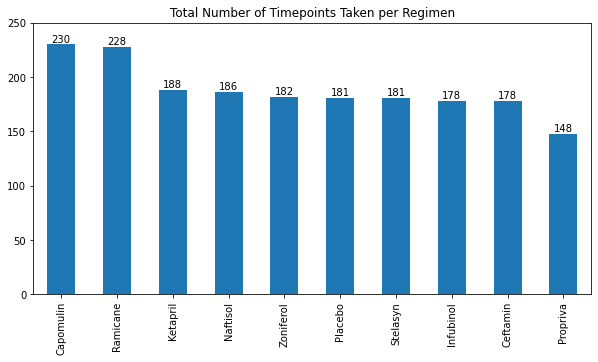

In [100]:
max_c(15)
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using Pandas.

total_grp = mouse_trial_data.groupby(by = 'Drug Regimen')

mreg_dict = dict.fromkeys(reg_list)
for r in reg_list:
    mreg_dict[r] = [x[1] for x in mreg_tups if x[0] == r]

tp_totals = dict.fromkeys(reg_list)
for r in reg_list:
    tp_count = total_grp.get_group(r)['Timepoint'].count()
    tp_totals[r] = tp_count

tdf = pd.Series(tp_totals)
tdf = tdf.sort_values(ascending=False)
plt.ioff()
ind_val = [x for x in enumerate(tdf)]
plt.figure(figsize = (10,5))
for i in range(10):
    plt.text(ind_val[i][0], ind_val[i][1]+5, str(ind_val[i][1]),ha='center', va='center')
tdf.plot.bar(yticks = [0,50,100,150,200,250], title = 'Total Number of Timepoints Taken per Regimen')

plt.ion()


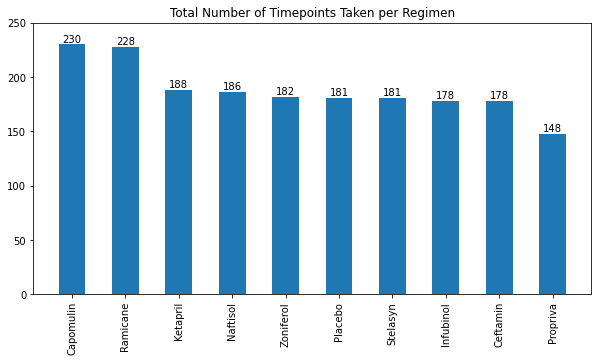

In [101]:
# Generate a bar plot showing the total number of timepoints for all mice tested for each drug regimen using pyplot.

plt.figure(figsize = (10,5))

plt.bar(tdf.index, height = tdf.values,width=.5)
plt.xticks(rotation='vertical')
plt.yticks([0,50,100,150,200,250])
plt.title('Total Number of Timepoints Taken per Regimen')
for i in range(10):
    plt.text(ind_val[i][0], ind_val[i][1]+5, str(ind_val[i][1]),ha='center', va='center')

plt.show()

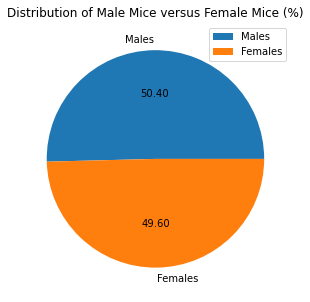

In [102]:
# Generate a pie plot showing the distribution of female versus male mice using Pandas
sexes = mouse_trial_data.drop_duplicates('Mouse ID')['Sex']
males = sexes.loc[mouse_trial_data['Sex'] == 'Male'].count() / len(m_set)
females = sexes.loc[mouse_trial_data['Sex'] == 'Female'].count() / len(m_set)
mf_df = pd.Series({'Males': males, 'Females': females})

fig = plt.figure()
pie_mf = mf_df.plot(kind = 'pie', title = 'Distribution of Male Mice versus Female Mice (%)',legend=True,labels = ['Males','Females'], autopct = '%.2f',figsize=(5,5))
bg = fig.set_facecolor('white')
mf_label = pie_mf.set_ylabel(None)



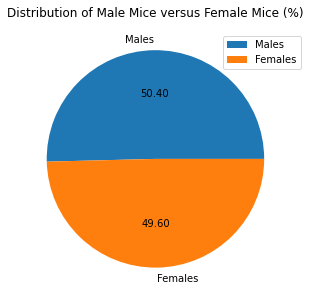

In [103]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot

mf_labels = ['Males', 'Females']
mf_data = [males, females]

fig, ax = plt.subplots()
ax.pie(mf_data,labels = mf_labels, autopct = '%.2f')
ax.set(xlabel=None, ylabel = None, title = 'Distribution of Male Mice versus Female Mice (%)')
leg = ax.legend(loc=(.75,.83))
bg = fig.set_facecolor('w')
size = fig.set_size_inches((5,5))

## Quartiles, Outliers and Boxplots

### Calculation of Final Tumor Volume

In [104]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

final_vol = {'Capomulin': '', 'Ramicane': '', 'Infubinol': '', 'Ceftamin': ''}

# Start by getting the last (greatest) timepoint for each mouse

last_tp = {'Mouse ID': '','Timepoint': ''}
last_tp['Mouse ID'] = mouse_trial_data['Mouse ID'].drop_duplicates().to_list()
last_tp['Timepoint'] = [mouse_trial_data['Timepoint'].loc[mouse_trial_data['Mouse ID'] == m].max() for m in last_tp['Mouse ID']]
last_tp = pd.DataFrame(last_tp['Timepoint'],index = pd.Index(last_tp['Mouse ID'],name='Mouse ID'),columns=['Timepoint'])

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint

final_tp = mouse_trial_data.merge(last_tp,on=['Mouse ID','Timepoint'])
grp_tp = final_tp.groupby(by = 'Drug Regimen')

for k in final_vol.keys():
    tv = grp_tp.get_group(k)['Tumor Volume (mm3)'].values
    final_vol[k] = tv

# For example:
pd.Series(final_vol['Ceftamin'])

0     62.9994
1     45.0000
2     56.0577
3     55.7428
4     48.7221
       ...   
20    45.0000
21    64.6349
22    61.3867
23    68.5947
24    64.7298
Length: 25, dtype: float64

### Calculate and Display Quartiles and Outlier Bounds

In [105]:
# Put treatments into a list for for loop (and later for plot labels)

treat_list = list(final_vol.keys())

# Create empty list to fill with tumor vol data (for plotting)

vol_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 
IQR = dict.fromkeys(treat_list)
quart = dict.fromkeys(treat_list)
for x in treat_list:
    IQR[x] = st.iqr(final_vol[x])
    quart[x] = list(np.percentile(final_vol[x],[25,50,75]))

iqr_df = pd.DataFrame(IQR,index = ['IQR'], columns=treat_list).T
quart_df = pd.DataFrame(quart,index = ['First Quartile','Second Quartile','Third Quartile'], columns=treat_list).T
bounds = quart_df.merge(iqr_df, left_index=True, right_index=True)
bounds.index.name = 'Drug Regimen'

lower = bounds['First Quartile'].sub(bounds['IQR'].mul(1.5))
upper = bounds['Third Quartile'].add(bounds['IQR'].mul(1.5))

limits = pd.concat([bounds,lower,upper],axis=1).rename(columns={0: 'Lower Outlier Bound', 1: 'Upper Outlier Bound'})

limits

,First Quartile,Second Quartile,Third Quartile,IQR,Lower Outlier Bound,Upper Outlier Bound
Drug Regimen,,,,,,
Capomulin,32.3774,38.1252,40.1592,7.7819,20.7046,51.8320
Ramicane,31.5605,36.5617,40.6590,9.0985,17.9127,54.3068
Infubinol,54.0486,60.1652,65.5257,11.4771,36.8329,82.7414
Ceftamin,48.7221,59.8520,64.2998,15.5778,25.3554,87.6665


### Isolate the Outliers, if any exist

In [106]:
# Create a list of all final tumor volumes
for x in treat_list:
    for i in range(len(final_vol[x])):
        vol_data.append(final_vol[x][i])

# Determine outliers using upper and lower bounds

up_outs = dict.fromkeys(treat_list)
low_outs = dict.fromkeys(treat_list)

for x in treat_list:
    up_lim = limits.at[x,'Upper Outlier Bound']
    low_lim = limits.at[x,'Lower Outlier Bound']
    up_outs[x] = [y for y in final_vol[x] if y > up_lim]
    low_outs[x] = [z for z in final_vol[x] if z < low_lim]

outlier = low_outs['Infubinol'][0]

print(low_outs)
print(up_outs)
print(f'The single outlier between all four drug regimens is a tumor volume of {outlier} (mm3) for Infubinol.')

{'Capomulin': [], 'Ramicane': [], 'Infubinol': [36.3213458], 'Ceftamin': []}
{'Capomulin': [], 'Ramicane': [], 'Infubinol': [], 'Ceftamin': []}
The single outlier between all four drug regimens is a tumor volume of 36.3213458 (mm3) for Infubinol.


### Display Box Plot

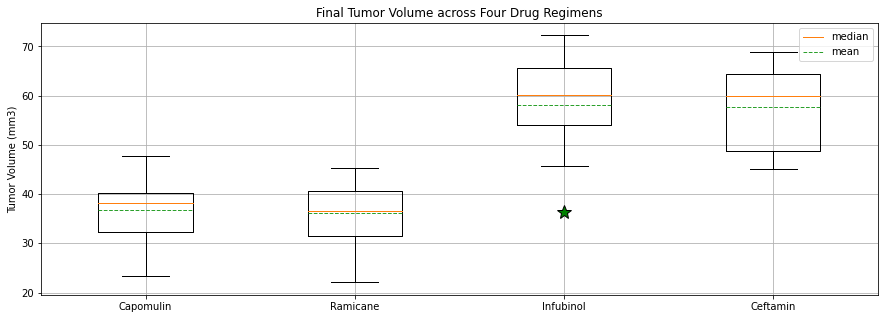

In [107]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

vol_data = [final_vol[x] for x in treat_list]

fig, ax = plt.subplots(figsize = (15,5))
ax.set_title('Final Tumor Volume across Four Drug Regimens')
ax.set_ylabel('Tumor Volume (mm3)')
bx = ax.boxplot(vol_data, labels = final_vol.keys(), flierprops=dict(marker='*',markerfacecolor='g',markersize=15),showmeans=True,meanline=True)
plt.legend([bx['medians'][0], bx['means'][0]], ['median','mean'])
plt.grid(b=True)

## Line and Scatter Plots

### Generate Random Line Plot
#### This code will generate a line plot for a random mouse in the Capomulin group.

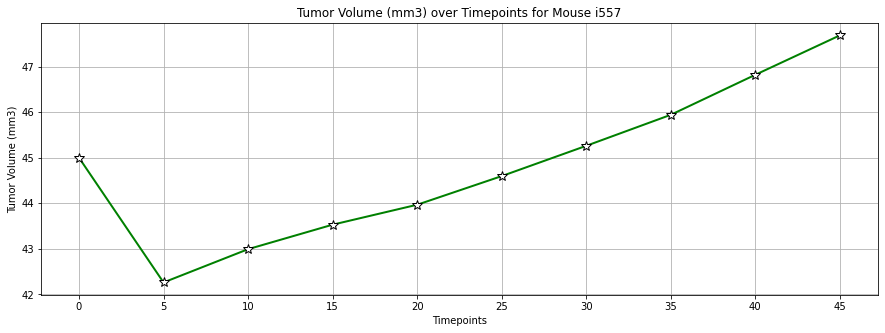

In [108]:
# Generate a line plot of tumor volume vs. time point for a mouse treated with Capomulin

cap = total_grp.get_group('Capomulin')
cap_mice = list(cap.drop_duplicates('Mouse ID')['Mouse ID'])
mouse = np.random.choice(cap_mice)
tumor_vol = list(mouse_trial_data['Tumor Volume (mm3)'].loc[mouse_trial_data['Mouse ID'] == mouse])
time_point = list(mouse_trial_data['Timepoint'].loc[mouse_trial_data['Mouse ID'] == mouse])

fig, ax = plt.subplots(figsize = (15,5))
plt.grid(b=True)
ax.set_title(f'Tumor Volume (mm3) over Timepoints for Mouse {mouse}')
ax.set_xlabel('Timepoints')
ax.set_xticks([0,5,10,15,20,25,30,35,40,45])
ax.set_ylabel('Tumor Volume (mm3)')
line = ax.plot(time_point,tumor_vol,color = 'g', linewidth = 2, marker='*',markersize=10,markerfacecolor = 'w',markeredgecolor = 'k')


### Generate Scatter Plot

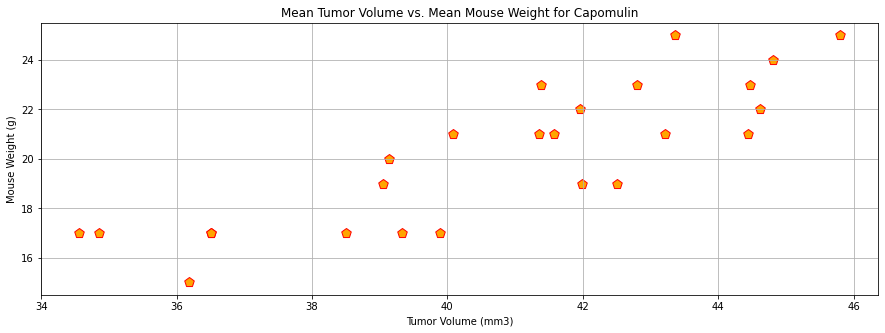

In [109]:
# Generate a scatter plot of average tumor volume vs. mouse weight for the Capomulin regimen

avg_tv = [cap['Tumor Volume (mm3)'].loc[cap['Mouse ID'] == m].mean() for m in cap_mice]
avg_g = [cap['Weight (g)'].loc[cap['Mouse ID'] == m].mean() for m in cap_mice]

avg_tv_g = [[float(avg_tv[i]),float(avg_g[i])] for i in range(len(avg_tv))]
avg_tv_g.sort(key=lambda x: x[0])

avg_tv = [avg_tv_g[i][0] for i in range(len(avg_tv))]
avg_g = [avg_tv_g[i][1] for i in range(len(avg_g))]


fig, ax = plt.subplots(figsize = (15,5))
plt.grid(b=True)
ax.set_title('Mean Tumor Volume vs. Mean Mouse Weight for Capomulin')
ax.set_xlabel('Tumor Volume (mm3)')
ax.set_ylabel('Mouse Weight (g)')
scatter = ax.scatter(avg_tv,avg_g,marker='p',s = 100,c = 'orange', edgecolor = 'red')
plt.show()

## Correlation and Regression
### Calculate Pearson's Correlation Coefficient

In [110]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
# We must assume that this sample comes from a normal distribution

pearson_co, pearson_p = st.pearsonr(avg_tv,avg_g)
print(f"Pearson's test gave a correlation score of r = {pearson_co} with a p-value of p = {pearson_p}.")


Pearson's test gave a correlation score of r = 0.8419363424694718 with a p-value of p = 1.3225722434712687e-07.


## Observation
The Pearson correlation coefficient measures strength of linearity between two variables. It does so best when the variables are normally distributed.
This test returns a value between -1 and +1, with 0 implying no correlation.
For our purposes, an alpha value of 0.05 will work.

Our sample coefficient is fairly close to +1, which would usually imply a strong, postive linear relationship.

In other words, as average tumor volume increases or decreases, so does average mouse weight, which heuristically makes total sense. If the tumor loses volume, then surely the mouse will weigh less, and the same holds for gaining volume. Then, if the two variables have a linear relationship, not only to they grow and shrink together, they do so at a constant rate.
Furthermore, the p-value being so much smaller than alpha would allow the user to reject the hypothesis that these variables have no correlation.

However, due to the small sample size, our sample coefficient is not an unbiased estiamtor of the population coefficient. In other words, the expected value of our estimator is different from the true value of the parameter. The p-values can also be misleading for such a small sample, leading to Type 1 or 2 errors. In the case of a smaller sample, an adjusted correlation coefficient is used, of which there are three estimations.

Finally, we should test for normality in our sample to see if the Pearson correlation test works best for this case. If the data is not normal, then this test may not be efficient, or would not perform well for a small data set like ours.

### The Three Adjusted Correlation Coefficients

In [111]:
# Setting up the Gaussian hypergeometric function

args = [1/2, 1/2, (len(avg_tv) - 1)/2, 1 - pearson_co**2]
gauss_hypergeo = spec.hyp2f1(*args)

# Calculate the three estimations of the adjusted correlation coefficient

r_adj_one = pearson_co * gauss_hypergeo
r_adj_two = pearson_co * (1 + (1 - pearson_co**2)/(2 * len(avg_tv)))
r_adj_three = np.sqrt(1 - ((1 - pearson_co**2) * (len(avg_tv) - 1))/(len(avg_tv) - 2))

# Setting up the Beta distribution for the two-tailed p-values

a = len(avg_tv)/2
dist = st.beta(a - 1, a - 1, loc = -1, scale = 2)

# Calculate the two-tailed p-values for our estimates

p_one = 2 * dist.cdf(-abs(r_adj_one))
p_two = 2 * dist.cdf(-abs(r_adj_two))
p_three = 2 * dist.cdf(-abs(r_adj_three))

print((r_adj_one,p_one))
print(f'The difference between the first adjusted r-value and original coefficient is {r_adj_one - pearson_co}.')
print((r_adj_two,p_two))
print(f'The difference between the second adjusted r-value and original coefficient is {r_adj_two - pearson_co}.')
print((r_adj_three,p_three))
print(f'The difference between the third adjusted r-value and original coefficient is {r_adj_three - pearson_co}.')

(0.8471776907611954, 9.22098613053904e-08)
The difference between the first adjusted r-value and original coefficient is 0.005241348291723624.
(0.8468388232079935, 9.442325598711167e-08)
The difference between the second adjusted r-value and original coefficient is 0.004902480738521731.
(0.8343850459939349, 2.175088199074306e-07)
The difference between the third adjusted r-value and original coefficient is -0.007551296475536873.


## Observation
The three adjusted coefficients are derived to be unbiased estimators with minimum variance, which aproach the original coefficient as the sample size increases. 

We can clearly see that all three adjusted coefficients are very close to the original r-value, all with very small p-values. Therefore, the need to adjust the coefficient appears to be unnecesary in the end. Of course, this could imply that the positive linearity of this sample is undisputable, no matter the size. However, we've made no attempt to test the normality of these samples. Should the samples appear to be normal, there is a strong case for our Pearson coefficients.

### Normality tests for Average Tumor Volume and Average Mouse Weight

The average tumor volume data has a skew value of -0.38972740399958444 and a kurtosis value of -0.8653443066355706.
The average mouse weight data has a skew value of 0.05107325633848454 and a kurtosis value of -1.0923894081265006.
The Shapiro-Wilk test yields values of 0.9513955116271973 (tumor volume) and 0.9339247941970825 (mouse weight).
These test values have p-values of 0.26949483156204224 and 0.10710319876670837, respectively.
The vertical red line in each plot represents the sample mean.


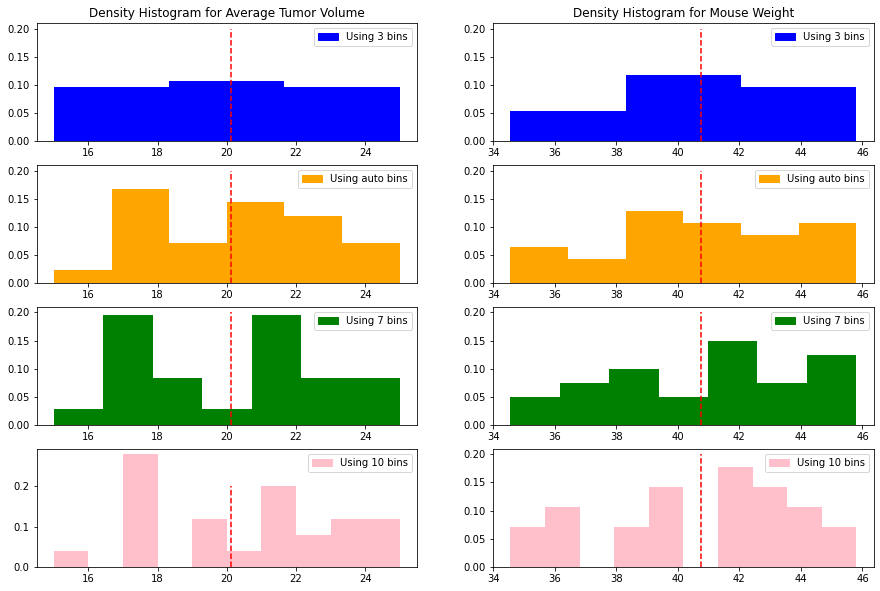

In [112]:
# Testing the null hypothesis that our samples come from a normal distribution

tv_skew, tv_kurt = st.skew(avg_tv), st.kurtosis(avg_tv)
tv_norm, tv_p = st.shapiro(avg_tv)
g_skew, g_kurt, = st.skew(avg_g), st.kurtosis(avg_g)
g_norm, g_p = st.shapiro(avg_g)

print(f"The average tumor volume data has a skew value of {tv_skew} and a kurtosis value of {tv_kurt}.")
print(f"The average mouse weight data has a skew value of {g_skew} and a kurtosis value of {g_kurt}.")
print(f"The Shapiro-Wilk test yields values of {tv_norm} (tumor volume) and {g_norm} (mouse weight).")
print(f"These test values have p-values of {tv_p} and {g_p}, respectively.")
print(f"The vertical red line in each plot represents the sample mean.")

plt.ioff()
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8)) = plt.subplots(nrows = 4, ncols = 2, figsize=(15,10))
axs = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

bin_choice = [3,'auto', 7, 10]
colors = ['blue', 'orange', 'green', 'pink']
e_patches = [mpatches.Patch(color=colors[i], label=f'Using {bin_choice[i]} bins') for i in range(4)]
o_patches = [mpatches.Patch(color=colors[i], label=f'Using {bin_choice[i]} bins') for i in range(4)]

for i in range(4):
    axs[2*i].hist(avg_g,bins = bin_choice[i], density=True, color = colors[i],label = bin_choice[i])
    axs[2*i].vlines(np.mean(avg_g),ymin=0,ymax=0.2,linestyles='dashed', colors='red',label = 'sample mean')
    axs[2*i].legend(handles=[e_patches[i]])

    axs[2*i+1].hist(avg_tv,bins = bin_choice[i], density=True, color= colors[i],label = bin_choice[i])
    axs[2*i+1].vlines(np.mean(avg_tv),ymin=0,ymax=0.2,linestyles='dashed', colors='red',label = 'sample mean')
    axs[2*i+1].legend(handles=[o_patches[i]])

ax1.set_title('Density Histogram for Average Tumor Volume')
ax2.set_title('Density Histogram for Mouse Weight')

plt.ion()
plt.show()

## Observation
This normality test compares the skewness and kurtosis statisics of a sample to those of a standard normal distribution. 
Intuitevely, skewness measures the asymmetry of a sample's probability distribution. Not so intuitevely, kurtosis measures how 'heavy' the tails of a distribtuion are, or more specifically how dense the values are outside of the interquantile range, i.e. the outliers. 

If the sample is indeed normally distributed, the skew should be close to zero, as should the kurtosis, depending on the definition of kurtosis used. (The Pearson standard of kurtosis puts a standard normal distribution at a kurtosis of 3).

The results here are, in one word, inconclusive. We do not have enough samples to create a particularly dense histogram. This can make the shape difficult to nail down. The number of bins can greatly impact the shape of the histograms, given our small sample size.

However, for this number of bins, we can see that even with 3 bins, the tumor volume data has consistent negative skewness, which would certainly suggest that it is not a standard normal distribution! It appears as though we do not have a lot of data very close to the mean, as there are a couple valleys, and not peaks, at the red  mean line. There aren't any features of the mouse weight graph that point to normality. It looks to have a bimodal distribution, although that could be a result of the bin number.

As far as the test values go, neither have small enough p-values to reject the null hypothesis. This only means that we cannot reject them being normally distributed, so there is still a chance that they are normal. Neither variable's test statistic is particularly close to zero, which would be the normal value. However, their statistics may appear to be much more normal compared to data that allows the null hypothesis to be rejected!

Since the case for standard normality is not strong, let's explore fitting the data to other distributions, particularly normal-esque distributions.

### Kernel Density Estimation for Tumor Volume and Mouse Weight
#### Let's take a better look at the distribution shapes.

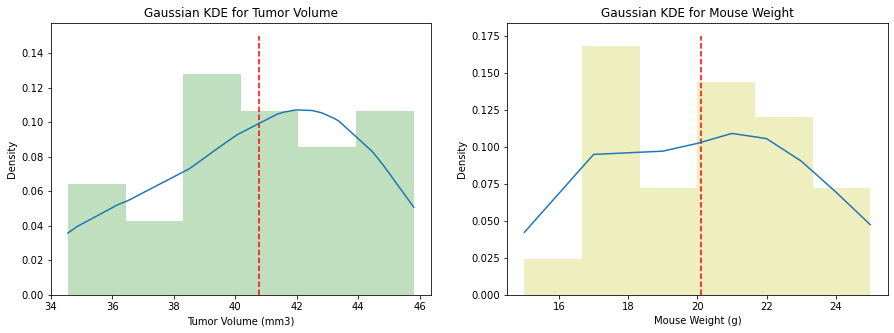

In [113]:
# Kernel Density Estimation (Gaussian) for our data
    #Plotted with respective histogram with the 'auto' number of bins

avg_g.sort()

tv_kde = list(st.gaussian_kde(avg_tv)(avg_tv))
g_kde = list(st.gaussian_kde(avg_g)(avg_g))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

ax1.set_title('Gaussian KDE for Tumor Volume')
ax2.set_title('Gaussian KDE for Mouse Weight')
ax1.set_ylabel('Density')
ax2.set_ylabel('Density')
ax1.set_xlabel('Tumor Volume (mm3)')
ax2.set_xlabel('Mouse Weight (g)')
ax1.vlines(np.mean(avg_tv),ymin=0,ymax=0.15,linestyles='dashed', colors='red')
ax2.vlines(np.mean(avg_g),ymin=0,ymax=0.175,linestyles='dashed', colors='red')


kde1 = ax1.plot(avg_tv,tv_kde)
kde2 = ax2.plot(avg_g,g_kde)
n1, bins1, patch1 = ax1.hist(avg_tv,bins='auto',density=True, alpha=.25,color='g')
n2, bins2, patch2 = ax2.hist(avg_g,bins='auto',density=True, alpha=.25,color='y')

hist1_xy = [(bins1[i],n1[i]) for i in range(len(n1))]
hist2_xy = [(bins2[i],n2[i]) for i in range(len(n2))]

plt.show()

## Observation
This analysis certainly offers some clarity into the normality of each variable. For this bin size, the average tumor volume density estimate appears to be rather well-fit. While the actual densities are quite different between the histogram and the mouse weight estimate, they seem to follow a similar shape. We can clearly see that the average tumor volume distribution estimation behaves like a negatively-skewed bell-shaped curve. While this may not be normal, it is certainly a clearer picture than the mouse weight density plot. 

Due to repetition of values, we essentially only have nine data points of mice weight, which produces a skeleton of a distribution. It does appear, however, that its distribution could be bimodal, in other words, have two peaks.

To end this analysis, I'll be departing from a single regimen's average tumor volume and look at mouse deaths and I'll compare the net tumor growths for each regimen. I'll define a function to help narrow down the choice of probabilty distribution to fit to a data set with various tests, and use it to compare the net tumor growth between regimens. Specifically, do any of the regimen's behave like the placebo? Which regimen was least lethal and which distribution had the steepest negative growth? Given the 'best' regimen, are there any other regimens that appear to come from the same distribution?

### Best-Fit Distribution

In [114]:

dlist = ['gamma', 'lognorm', 'rayleigh','skewnorm', 'norm', 'gumbel_l', 'genextreme']

# Fit the data to any distribution
def fitter(data,dist):

    data_copy = np.array(data)
    data = []
    data_copy.sort()
    first_q, med, third_q, data_iqr = *np.quantile(data_copy,[.25,.5,.75]), st.iqr(data_copy)
    lower_data = first_q - 1.5*data_iqr
    upper_data = third_q + 1.5*data_iqr
    for x in data_copy:
        if x < upper_data and x > lower_data:
            data.append(x)
        else:
            pass
    data = np.array(data)

    rv = getattr(st,dist)
    params = rv.fit(data)
    pdf = rv.pdf(data,*params)
    summary = rv.stats(*params, moments='msk')
    summary = [summary[0],rv.ppf(0.5,*params),params[-1],summary[1],summary[2]]
    data_sum = np.array([np.mean(data), med, np.std(data), st.skew(data), st.kurtosis(data)],dtype='f4')
    sum_diff = []
    for i in [0,1,2,3,4]:
        if i == 1:
            sum_diff.append(rv.ppf(0.5,*params)-med)
        else:
            diff = summary[i]-data_sum[i]
            sum_diff.append(diff)

    data_qs = [(x - params[-2])/ params[-1] for x in data]
    n = data.shape[0]
    th_qs = rv.ppf((np.arange(1.0, n + 1) / (n + 1)),*params[0:-2])
    samp_hist, edges = np.histogram(data,bins='auto',density=True)
    shap_test, shap_p = st.shapiro(data)


    bins = [edges[i] for i in range(len(edges))]
    h_val= []
    for x in data:
        for i in range(len(edges)-1):
            if x >= bins[i] and x<bins[i+1]:
                h_val.append(samp_hist[i])
        if x >= bins[len(edges)-1]:
            h_val.append(samp_hist[-1])
    
    is_norm, is_norm_p = st.normaltest(data)

    plt.ioff()
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,7))
    ax1.set_xlim(min(th_qs),max(th_qs))
    ax1.set_ylim(min(data_qs),max(data_qs)) 
    top = max(np.histogram(data,bins='auto',density=True)[0])*1.05
    top2 = max(pdf)*1.05
    if dist == 'beta':
        ax2.set_ylim(0,top)
    else:
        ax2.set_ylim(0,max([top,top2]))

    ax1.set_title(f'Q-Q Plot for {dist} Distribution')
    ax1.plot(np.arange(min(th_qs),max(th_qs),0.01),np.arange(min(th_qs),max(th_qs),0.01),label='y = x', color = 'orange')
    qq(data,rv,fit = True, ax = ax1, line = 'r', label= 'Sample vs. Theoretical Quantiles')
    ax1.legend(loc=2)
    ax2.set_title(f'Density Histogram against KDE and EPDF')
    ax2.hist(data,bins ='auto',density=True,color='red',alpha=0.35,label='Data Histogram')
    ax2.plot(data,pdf,color='blue',label='Estimated Probability Density Function')
    ax2.plot(data,st.gaussian_kde(data)(data), label='Gaussian Kernel Density Estimation', color = 'green')
    ax2.vlines(np.mean(data),ymin=0,ymax=top,linestyles='dashed', colors='red',label='Sample Mean')
    ax2.legend(loc=4)
    plt.ion()
    plt.show()
    print('Summary of how the distribution',dist,'fits the data set (with normality testing):')
    print(pd.DataFrame.from_dict({'Sample Stats': data_sum, 'Theoretical Stats': summary, 'Difference': sum_diff}, orient='index', columns=['Mean', 'Median', 'Variance', 'Skew', 'Kurtosis']))
    print('''The skew-kurtosis test for normality supplied the statistic''',is_norm,'''with a p-value of''',is_norm_p,'''.''')
    print('''The Shapiro-Wilk test for normality yielded''',shap_test,'''as the test statistic, with a p-value of''',shap_p,'''.''')
    print(f'Optimal parameters: {params}')
    return 

tg_dict = {r: list(reg_grp.get_group(r)['Net Tumor Growth'].values) for r in reg_list}

fitter()

TypeError: fitter() missing 2 required positional arguments: 'data' and 'dist'

In [ ]:
last_tp.insert(1,'Drug Regimen',[mouse_trial_data['Drug Regimen'].loc[mouse_trial_data['Mouse ID'] == x].values[0] for x in last_tp.index])

In [ ]:
dead_mice = last_tp.groupby('Drug Regimen')
def deaths(reg):
    return dead_mice.get_group(reg).loc[dead_mice.get_group(reg)['Timepoint']<45].shape[0]
r_deaths = []
for r in reg_list:
    r_deaths.append((r,deaths(r)))
r_deaths.sort(key=lambda x: x[1],reverse=True)
death_dict = dict(r_deaths)

In [ ]:
fig, ax = plt.subplots()
fig.set_facecolor('xkcd:light mauve')
ax.set_facecolor('xkcd:robin egg blue')
xlab = ax.set_xlabel('Drug Regimen')
ylab = ax.set_ylabel('Mouse Deaths')
figset = fig.set_figwidth(15)
title = plt.title('Mouse Deaths during each Drug Trial',fontsize=16)
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
bars = ax.bar(list(death_dict.keys()),list(death_dict.values()),color=plt.get_cmap('RdYlGn_r')(rescale(list(death_dict.values()))))

In [ ]:

fig = plt.figure(figsize=[20,15])
reg_list = list(death_dict.keys())
for i in range(10):
    plt.ioff()
    tg_dict[reg_list[i]].sort()
    ax = fig.add_subplot(2,5,i+1)
    ax.hist(tg_dict[reg_list[i]],bins='auto',density=True,alpha=.3,color='green',label=f'{reg_list[i]} Histogram')
    kde = st.gaussian_kde(tg_dict[reg_list[i]])(tg_dict[reg_list[i]])
    ax.plot(tg_dict[reg_list[i]],kde, color = 'blue',label = f'{reg_list[i]} KDE')
    ax.legend()
    ax.set_title('''Net Tumor Growth \n Density Estimations for \n regimen ''' + reg_list[i])
    plt.ion()
plt.show()

## Observation

Here, we can see just how non-normal our data may be in its current state. Clearly, we have a few bimodal distributions, with Zoniferol, Ceftamin, Naftisol, the Placebo,  and possibly Ketapril and Propriva as well. Thus, as things stand, we can confidently say that, by inspection, these distributions are not normal, at least not standard normal. More likely, they follow a bimodal normal distribution, or the sum of two normal distributions with each piece weighted parametrically. We do have a few bell-curves at least, however they are all skewed at least slightly, pointing again to non-normality.

In [ ]:
#Each Drug Regimen was tested on 24 or 25 mice
#This will split the Net Tumor Growth data sets along that line

mice24, mice25 = [], []

for r in reg_list:
    if len(tg_dict[r]) != 25:
        mice24.append(r)
    else:
        mice25.append(r)

#For ANOVA purposes, this groups data sets together if their sample Standard Deviations are less than a unit away
corr = set([frozenset([r,s]) for r in reg_list for s in reg_list if r != s and abs(final['std'].loc['Net Tumor Growth'][r] - final['std'].loc['Net Tumor Growth'][s]) < 1])
corr = list(map(list,corr))

#This dictionary contains every possible list of 25-mouse regimens with one data point removed
trim_dict = dict.fromkeys(mice25)
for r in mice25:
    dict24 = dict.fromkeys([tg_dict[r][i] for i in range(25)])
    for i in range(25):
        list24 = [v for v in tg_dict[r] if v != tg_dict[r][i]]
        dict24[tg_dict[r][i]] = list24
    trim_dict[r] = dict24

new_musig = dict.fromkeys(mice25)
for r in mice25:
    musig_dict = dict.fromkeys([tg_dict[r][i] for i in range(25)])
    for i in range(25):
        new_mean, new_std = np.mean(trim_dict[r][tg_dict[r][i]]), np.std(trim_dict[r][tg_dict[r][i]])
        musig_dict[tg_dict[r][i]] = (new_mean,new_std)
    new_musig[r] = musig_dict

musig_diff = dict.fromkeys(mice25)
for r in mice25:
    diff_dict = dict.fromkeys([tg_dict[r][i] for i in range(25)])
    for i in range(25):
        mean_diff, std_diff = abs(new_musig[r][tg_dict[r][i]][0] - np.mean(tg_dict[r])), abs(new_musig[r][tg_dict[r][i]][1] - np.std(tg_dict[r]))
        diff_dict[tg_dict[r][i]] = (mean_diff,std_diff)
    musig_diff[r] = diff_dict

reg_combos = dict.fromkeys(mice25)
for r in mice25:
    lin_combos = dict.fromkeys(tg_dict[r])
    for j in tg_dict[r]:
        combo = musig_diff[r][j][0] + musig_diff[r][j][1]
        lin_combos[j] = combo
    reg_combos[r] = lin_combos

least_important = dict.fromkeys(mice25)
for r in mice25:
    min_diff = min(reg_combos[r].values())
    list(reg_combos[r].values()).index(min_diff)
    least_important[r] = [list(reg_combos[r].keys())[list(reg_combos[r].values()).index(min_diff)], min_diff]
trimmed_sets = dict.fromkeys(reg_list)
for r in mice25:
    trimmed_sets[r] = [v for v in tg_dict[r] if v != least_important[r][0]]
for r in mice24:
    trimmed_sets[r] = tg_dict[r]

trimmed_sets['Placebo'].sort()

In [ ]:
plt.ioff()
fig = plt.figure(figsize=(20,20),frameon=False)
plt.box(False)
plt.title('Linear Correlation of Net Tumor Growth in the Placebo trial and the Other Trials',y=1.03,fontsize=20)
placebo_reg_list = [r for r in trimmed_sets if r != 'Placebo']
for i in range(1,10):
    trimmed_sets[placebo_reg_list[i-1]].sort()
    ax = fig.add_subplot(3,3,i)
    ax.scatter(trimmed_sets['Placebo'],trimmed_sets[placebo_reg_list[i-1]])
    m, b = np.polyfit(trimmed_sets['Placebo'],trimmed_sets[placebo_reg_list[i-1]],1)
    line = ax.plot(np.arange(min(trimmed_sets['Placebo'])*1.25,max(trimmed_sets['Placebo'])*1.25,.1),[m*x + b for x in np.arange(min(trimmed_sets['Placebo'])*1.25,max(trimmed_sets['Placebo'])*1.25,.1)],color='red')
    ax.set_title(f'Placebo vs. {placebo_reg_list[i-1]}')
    ax.set_xlabel(f'Net Tumor Growth under Placebo')
    ax.set_ylabel(f'Net Tumor Growth under {placebo_reg_list[i-1]}')
    r2 = met.r2_score(trimmed_sets[placebo_reg_list[i-1]],[m*x + b for x in trimmed_sets['Placebo']])
    proxy = mpatches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    line_proxy = mlines.Line2D([], [], color ='red')
    ax.legend(handles = [line_proxy,proxy],labels = ('Best-Fit Line', f'r^2 value: \n {round(r2,4)}'))
plt.ion()
plt.show()

In [ ]:
plt.ioff()
fig = plt.figure(figsize=(20,20),frameon=False)
plt.box(False)
plt.title('Linear Correlation of Net Tumor Growth in the Capomulin trial and the Other Trials',y=1.03,fontsize=20)
Capomulin_reg_list = [r for r in trimmed_sets if r != 'Capomulin']
for i in range(1,10):
    trimmed_sets[Capomulin_reg_list[i-1]].sort()
    ax = fig.add_subplot(3,3,i)
    ax.scatter(trimmed_sets['Capomulin'],trimmed_sets[Capomulin_reg_list[i-1]])
    m, b = np.polyfit(trimmed_sets['Capomulin'],trimmed_sets[Capomulin_reg_list[i-1]],1)
    line = ax.plot(np.arange(min(trimmed_sets['Capomulin'])*1.25,max(trimmed_sets['Capomulin'])*1.25,.1),[m*x + b for x in np.arange(min(trimmed_sets['Capomulin'])*1.25,max(trimmed_sets['Capomulin'])*1.25,.1)],color='red')
    ax.set_title(f'Capomulin vs. {Capomulin_reg_list[i-1]}')
    ax.set_xlabel(f'Net Tumor Growth under Capomulin')
    ax.set_ylabel(f'Net Tumor Growth under {Capomulin_reg_list[i-1]}')
    r2 = met.r2_score(trimmed_sets[Capomulin_reg_list[i-1]],[m*x + b for x in trimmed_sets['Capomulin']])
    proxy = mpatches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
    line_proxy = mlines.Line2D([], [], color ='red')
    ax.legend(handles = [line_proxy,proxy],labels = ('Best-Fit Line', f'r^2 value: \n {round(r2,4)}'))
plt.ion()
plt.show()

### Linear Model for Mean Tumor Volume vs. Mouse Weight

In [ ]:
# Generate the parameters for the model

lin_reg = st.linregress(avg_tv, avg_g)
fnc = [lin_reg.slope*x + lin_reg.intercept for x in avg_tv]

# Plot the model against the scatter plot

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title('Linear Model for Mean Tumor Volume vs. Mouse Weight')
ax.set_xlabel('Tumor Volume (mm3)')
ax.set_ylabel('Mouse Weight (g)') 
scatter = ax.scatter(avg_tv,avg_g,marker='p',s = 100, c = 'orange', edgecolor = 'red')
line = ax.plot(avg_tv,fnc,color='g')
line_proxy = mlines.Line2D([], [], color ='green')
proxy = mpatches.Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
ax.legend(handles = [scatter,line_proxy,proxy],labels = ('Original Data', 'Best-Fit Line', f'r^2 value: \n {round(met.r2_score(avg_g,fnc),4)}'))
plt.show()


## Observation
This model has an r-value of 0.841936342469472, so it appears that the model fits well and the relationship between the two variables is a linear one.  The p-value is 1.3225722434712478e-07, far below a significance level of 0.05, so we can reject the null hypothesis that the slope of the true best-fit line is zero.
Again, the small sample size makes it difficult to confidently reject the null hypothesis, but simply by looking at the model's fit, the data seems to be positively linear. In other words, the two variables increase and decrease together, at a constant rate. If a tumor increases or decreases in volume, then it is given that the weight of the mouse will increase or decrease, respetively, so that correlation is clear. 

What's unclear is the reverse relationship: how does a change in mouse weight affect the tumor volume? Our analysis points to the relationship also being positively linear, yet we must remain skeptical as long as our data set remains small! For example, our plots above showed 'strong' linear relationships between every regimen group with the Placebo's performance AND Capomulin's! So these results, specifically the stats and the p-values, should be taken with a grain of salt.